In [1]:
import glob
import os
import copy

import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl

In [2]:
import importlib
%matplotlib notebook

In [7]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot
#import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
#import analyze2p.extraction.rois as roiutils
#import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.scatter as sct

In [5]:
# Meta data
visual_areas=['V1', 'Lm', 'Li']
pplot.set_plot_params()
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [9]:
regr_list=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                                create_new=False)
    aligned_np, REGR_NP, regr_np_meas = sct.get_aligned_neuropil(dk, va, retinorun,
                                                        GVECTORS)
    regr_np_meas['aligned'] = False
    REGR_NP['aligned'] = True
    df_ = pd.concat([regr_np_meas, REGR_NP], axis=0, ignore_index=True)
    df_['visual_area'] = va
    df_['datakey'] = dk
    regr_list.append(df_)
    

    found: 20190522_JC089_fov1, Li dict_keys(['Li'])
    found: 20190527_JC092_fov3, Li dict_keys(['Li'])
    found: 20190528_JC092_fov1, Li dict_keys(['Li'])
    found: 20190602_JC091_fov1, Li dict_keys(['Li'])
    found: 20190606_JC091_fov1, Li dict_keys(['Li'])
    found: 20190607_JC091_fov1, Li dict_keys(['Li'])
    found: 20190609_JC099_fov1, Li dict_keys(['Li'])
    found: 20190612_JC099_fov1, Li dict_keys(['Li'])
    found: 20190614_JC091_fov1, Li dict_keys(['Li'])
    found: 20190617_JC099_fov1, Li dict_keys(['Li'])
    found: 20191012_JC113_fov1, Li dict_keys(['Li'])
    found: 20191012_JC113_fov2, Li dict_keys(['Li'])
    found: 20191017_JC113_fov1, Li dict_keys(['Li'])
    found: 20191018_JC113_fov1, Li dict_keys(['Li'])
    found: 20191105_JC117_fov1, Li dict_keys(['Li', 'Lm'])
    found: 20191106_JC120_fov1, Li dict_keys(['Li'])
    found: 20191111_JC120_fov1, Li dict_keys(['Li', 'Lm'])
    found: 20190423_JC076_fov1, Lm dict_keys(['Lm'])
    found: 20190430_JC078_fov1, Lm

In [10]:
all_regr = pd.concat(regr_list, axis=0, ignore_index=True)
print(all_regr.shape)

(216, 10)


In [33]:
pre_ = all_regr[~all_regr['aligned']].copy().reset_index(drop=True)
post_ = all_regr[all_regr['aligned']].copy().reset_index(drop=True)

In [47]:
worse = np.where(pre_['R2'].round(2)>post_['R2'].round(2))[0]

In [75]:
worse_datakeys = pre_.iloc[worse][['visual_area', 'datakey']]


In [92]:
all_worse = pd.merge(all_regr, worse_datakeys, on=['visual_area', 'datakey'], 
                     how='inner').drop_duplicates()
all_worse.head()

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond,aligned,visual_area,datakey
0,0.604807,5.284554,4.265583e-07,0.777694,0.090536,-16.472768,az,False,Li,20190522_JC089_fov1
1,0.853725,1.422103,3.301757e-13,0.923973,0.021094,0.160121,el,False,Li,20190522_JC089_fov1
2,0.615813,5.210452,2.849263e-07,0.784737,0.059503,-25.233946,az,True,Li,20190522_JC089_fov1
3,0.707435,2.011210,5.901216e-09,0.841092,0.029696,5.594582,el,True,Li,20190522_JC089_fov1
4,0.807627,5.363683,1.016263e-13,0.898681,0.069296,-12.690501,az,False,Li,20190528_JC092_fov1


In [93]:
for va, g in all_worse.groupby(['visual_area']):
    curr_dkeys = g['datakey'].unique()
    dkey_lut = dict((v, k) for k, v in enumerate(curr_dkeys))
    dkey_num = [dkey_lut[v] for v in g['datakey'].values]
    all_worse.loc[g.index, 'datakey_num'] = dkey_num

<IPython.core.display.Javascript object>


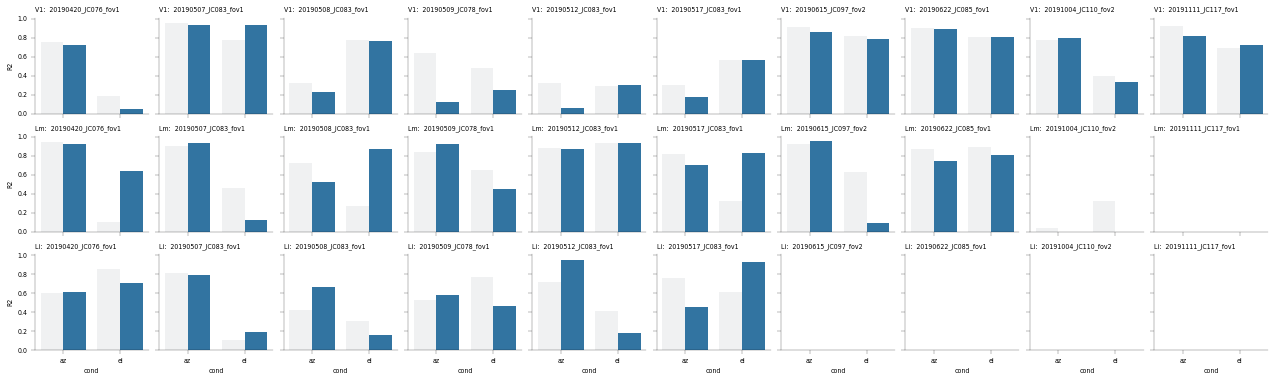

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


V1 0.0
V1 1.0
V1 2.0
V1 3.0
V1 4.0
V1 5.0
V1 6.0
V1 7.0
V1 8.0
V1 9.0
Lm 0.0
Lm 1.0
Lm 2.0
Lm 3.0
Lm 4.0
Lm 5.0
Lm 6.0
Lm 7.0
Lm 8.0
Lm 9.0
Li 0.0
Li 1.0
Li 2.0
Li 3.0
Li 4.0
Li 5.0
Li 6.0
Li 7.0
Li 8.0
Li 9.0


In [94]:
%matplotlib notebook
fg = sns.FacetGrid(data=all_worse, row='visual_area', row_order=visual_areas, 
                   height=1.7, col='datakey_num')
fg.map(sns.barplot, 'cond', 'R2', 'aligned')

for ax in fg.axes.flat:
    ax.set_title('')
    #pl.setp(ax.texts, text="")
    # remove the original texts
fg.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = fg.axes.flatten()
for ax in axes:
    currt = ax.get_title()
    ax.set_title('') # remove old
    va = currt.split(' ')[0]
    snum = float(currt.split(' ')[2])
    print(va, snum)
    dk = [k for k, v in dkey_lut.items() if v==snum][0]
    new_t = '%s:  %s' % (va, dk)
    ax.set_title(new_t, fontsize=6, loc='left')


In [145]:
va='Lm'
curr_ds = all_worse[all_worse.visual_area==va]

In [146]:
for (dk, cnd), g in curr_ds.groupby(['datakey', 'cond']):
    post = float(g[g.aligned]['R2'].round(2).values)
    pre = float(g[~g.aligned]['R2'].round(2).values)
    diff = post-pre
    if diff<0:
        print('%s, %s: pre, %.2f | post, %.2f' % (dk, cnd, pre, post)) #diff)

20190423_JC076_fov1, az: pre, 0.95 | post, 0.93
20190430_JC078_fov1, el: pre, 0.46 | post, 0.13
20190504_JC078_fov1, az: pre, 0.73 | post, 0.53
20190506_JC080_fov1, el: pre, 0.66 | post, 0.45
20190508_JC083_fov1, az: pre, 0.88 | post, 0.87
20190509_JC078_fov1, az: pre, 0.82 | post, 0.71
20190513_JC078_fov1, el: pre, 0.63 | post, 0.10
20190618_JC097_fov1, az: pre, 0.87 | post, 0.75
20190618_JC097_fov1, el: pre, 0.89 | post, 0.81
20191111_JC117_fov1, az: pre, 0.04 | post, 0.00
20191111_JC117_fov1, el: pre, 0.32 | post, 0.00


In [91]:
g

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond,aligned,visual_area,datakey
68,0.751544,4.012495,8.022210e-27,0.866916,0.031379,16.805055,az,False,V1,20190420_JC076_fov1
69,0.751544,4.012495,8.022210e-27,0.866916,0.031379,16.805055,az,False,V1,20190420_JC076_fov1
72,0.718691,4.269544,1.418926e-24,0.847756,0.031492,19.271050,az,True,V1,20190420_JC076_fov1
73,0.718691,4.269544,1.418926e-24,0.847756,0.031492,19.271050,az,True,V1,20190420_JC076_fov1


In [127]:
dk='20190615_JC097_fov2'
va='V1'
retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                            create_new=True)

... calculating global gradients (20190615_JC097_fov2, V1)


    found: 20190615_JC097_fov2, V1 dict_keys(['V1'])


<IPython.core.display.Javascript object>


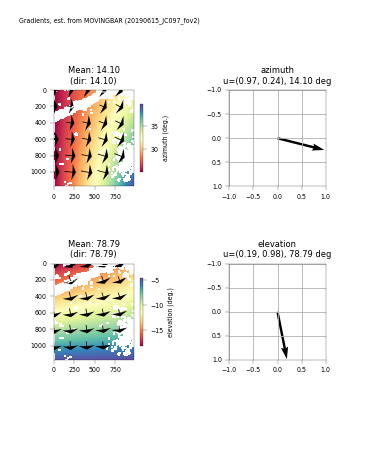

Text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (20190615_JC097_fov2)')

In [128]:
%matplotlib notebook
fig = sct.plot_gradients(dk, va, retinorun, cmap='Spectral')
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

In [131]:
aligned_np, REGR_NP, regr_np_meas = sct.get_aligned_neuropil(dk, va, retinorun,
                                                    GVECTORS)
# Save
sct.update_models(dk, va, REGR_NP)

# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

MEASURED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.915619 | 1.03722 | 1.79628e-175 |    0.95688  |     0.0130241 |     24.9659 | az     |
|  1 | 0.811831 | 1.33502 | 3.40108e-119 |    0.901016 |     0.0100562 |    -16.4017 | el     |
ALIGNED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.910576 | 1.06777 | 2.12411e-171 |    0.954241 |    0.0128081  |     23.0092 | az     |
|  1 | 0.792147 | 1.40311 | 3.2715e-112  |    0.890027 |    0.00987172 |    -17.1025 | el     |


<IPython.core.display.Javascript object>


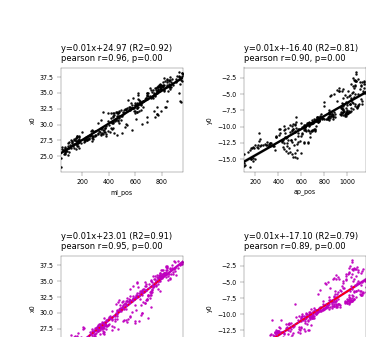

In [130]:
fig = sct.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)


In [136]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

Do model? True
... loading gradient vectors (20190615_JC097_fov2, V1)
    found: 20190615_JC097_fov2, V1 dict_keys(['V1'])
    found: 20190615_JC097_fov2, V1 dict_keys(['V1'])


<IPython.core.display.Javascript object>


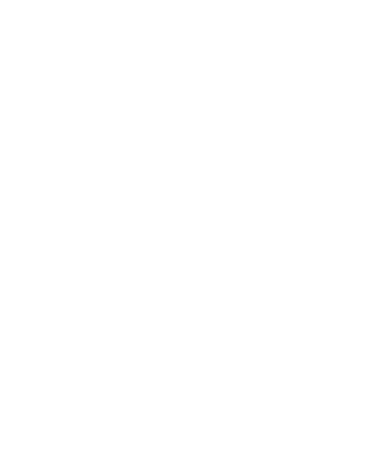

... estimating linear fit (20190615_JC097_fov2, V1)


<IPython.core.display.Javascript object>


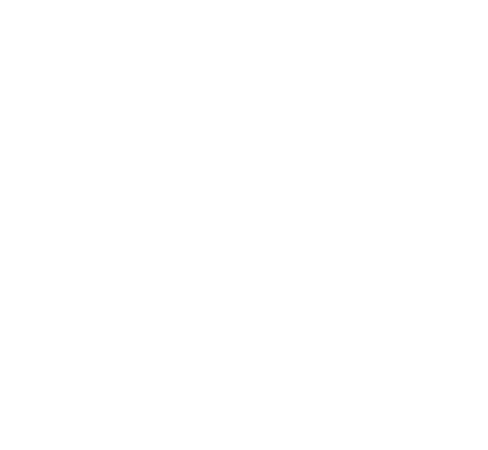

<IPython.core.display.Javascript object>


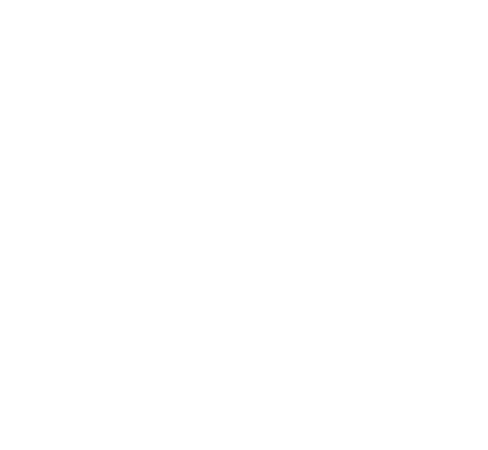

<IPython.core.display.Javascript object>


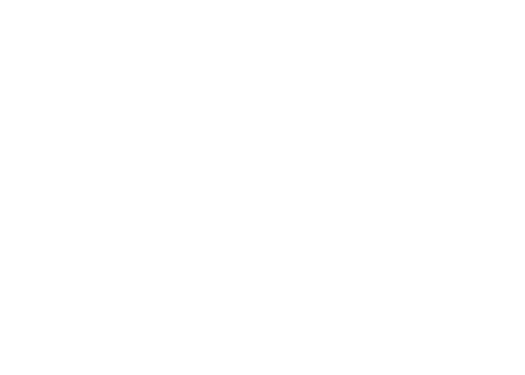

... calculating deviations


<IPython.core.display.Javascript object>


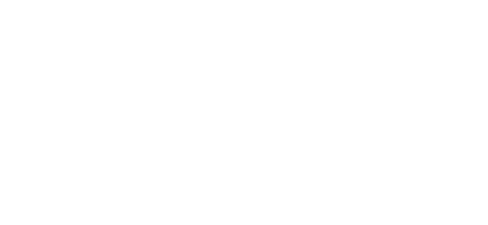

In [140]:
devs = sct.do_scatter_analysis(dk, va, experiment='rfs10', 
                               return_best_model=True,
                                do_gradients=False, do_model=True)

Do model? True
... loading gradient vectors (20190615_JC097_fov2, V1)
    found: 20190615_JC097_fov2, V1 dict_keys(['V1'])
    found: 20190615_JC097_fov2, V1 dict_keys(['V1'])


<IPython.core.display.Javascript object>


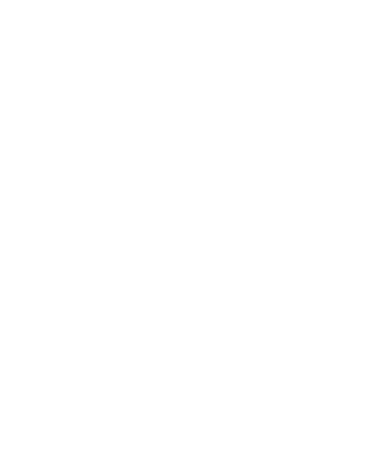

... estimating linear fit (20190615_JC097_fov2, V1)


<IPython.core.display.Javascript object>


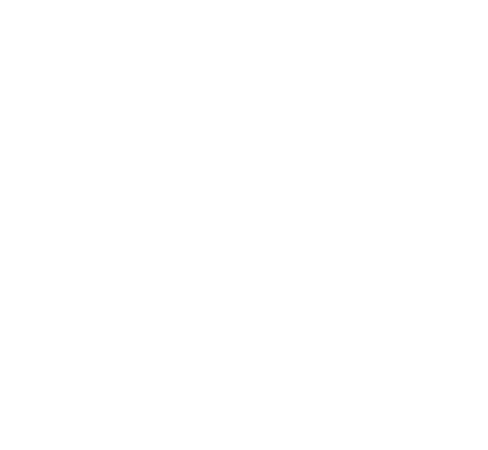

<IPython.core.display.Javascript object>


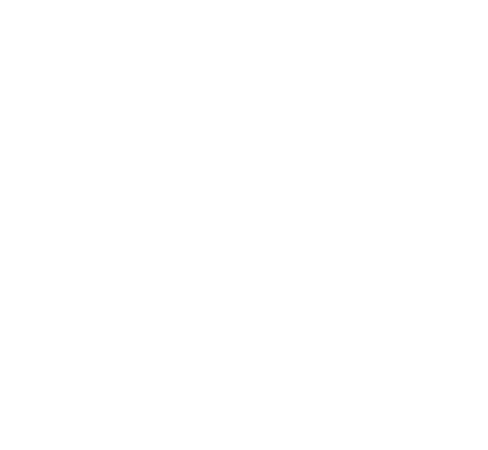

<IPython.core.display.Javascript object>


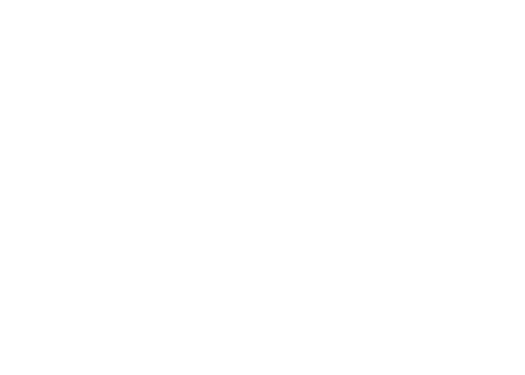

... calculating deviations


<IPython.core.display.Javascript object>


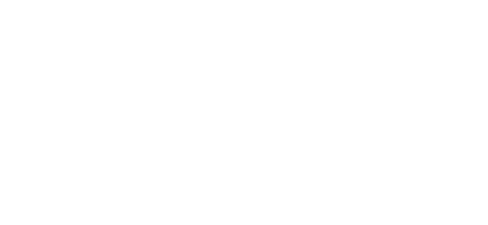

In [141]:
devs_aligned = sct.do_scatter_analysis(dk, va, experiment='rfs10', 
                               return_best_model=False,
                                do_gradients=False, do_model=True)

In [142]:
devs

,cell,deg_scatter,dist_scatter,inbounds,axis
0,4,2.735750,210.052458,False,az
1,7,26.442895,2030.300547,False,az
2,8,4.302492,330.347784,False,az
3,10,2.089309,160.418326,False,az
4,11,1.288590,98.938652,False,az
...,...,...,...,...,...
253,326,2.200826,218.853115,True,el
254,328,0.276903,27.535603,False,el
255,330,1.924810,191.405721,False,el
256,336,0.954041,94.871094,True,el


<IPython.core.display.Javascript object>


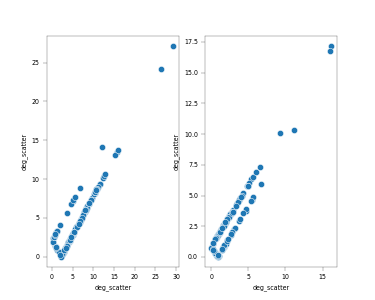

In [144]:
fig, axn  = pl.subplots(1,2)
for ax, (cnd, cnd_df) in zip(axn.flat, devs.groupby(['axis'])):
    cnd_df_aligned = devs_aligned[devs_aligned.axis==cnd]
    sns.scatterplot(cnd_df['deg_scatter'], cnd_df_aligned['deg_scatter'], ax=ax)